# Ranking feature importance based on class membership feature weights

In order to get more insight into how our classifiers are making a decision, and display this insight in our webapp, we wish to gather an idea of feature classification importance. The inspiration for this came from this image:
![Representation of feature weights](https://blog.openai.com/content/images/2017/04/sentiment-prediction.png)

<sup>(you can find the full animation in OpenAI's Sentiment Neuron research paper [here](https://blog.openai.com/unsupervised-sentiment-neuron/) )</sup>

To demonstrate how this is done, we use the LinearSVM classifer that was shown to be the best performer in the cross-comparison notebook. We simply extract the coefficients after training the classifier, match vocabularly indices to coefficients, and return them in tuples. Let's begin the process below, by importing the libraries we need, and setting up the classifier as before.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from get_df import get_data_frame

In [5]:
data_fm = get_data_frame()

data_fm.loc[data_fm['deceptive']=='d','deceptive']=1
data_fm.loc[data_fm['deceptive']=='t','deceptive']=0

data_fm.loc[data_fm['sentiment']=='positive','sentiment']=1
data_fm.loc[data_fm['sentiment']=='negative','sentiment']=0

data_x = data_fm['review']

data_y = np.asarray(data_fm['deceptive'],dtype=int)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=0)

cv = CountVectorizer()
tfidf = TfidfTransformer()

X_train_count = cv.fit_transform(X_train) # Transforming the Training reviews to count vectors and fitting for TF-idf
X_test_count = cv.transform(X_test) # Only transforming the test reviews to count vectors

X_train_tfidf = tfidf.fit_transform(X_train_count) # Transforming the fitted training Count Vectors
X_test_tfidf = tfidf.transform(X_test_count) 

feature_names = cv.get_feature_names()

model = LinearSVC(random_state=0) # Starting seed
model.fit(X_train_tfidf, y_train) 


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

We then define a function to help us visualise the coefficient weights.

In [7]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 print(top_coefficients)
 print(coef[top_coefficients])
 print(feature_names[top_coefficients])
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

Now let's run our model over our test set and plot the feature coefficients.

                                                Review True(0)/Deceptive(1)
0      (0, 8153)\t0.06649075057280888\n  (0, 8136)\...              Genuine
1      (0, 8067)\t0.057664501423470314\n  (0, 8039)...            Deceptive
2      (0, 8115)\t0.10299399585475007\n  (0, 8082)\...              Genuine
3      (0, 8082)\t0.07548347852701458\n  (0, 8069)\...              Genuine
4      (0, 8153)\t0.03647649120716597\n  (0, 8115)\...            Deceptive
5      (0, 8153)\t0.03518636481873234\n  (0, 8115)\...              Genuine
6      (0, 8094)\t0.04737467595730813\n  (0, 8067)\...            Deceptive
7      (0, 8153)\t0.04437056918219143\n  (0, 8003)\...            Deceptive
8      (0, 8145)\t0.12771110389490228\n  (0, 8039)\...              Genuine
9      (0, 8067)\t0.07472075779268482\n  (0, 8047)\...              Genuine
10     (0, 8115)\t0.10567803265159474\n  (0, 8100)\...              Genuine
11     (0, 8115)\t0.05611106669814392\n  (0, 8094)\...            Deceptive
12     (0, 8

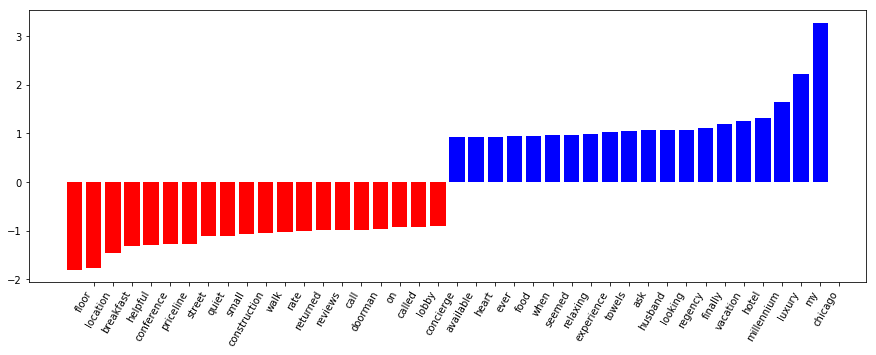

In [8]:
y_predictions = model.predict(X_test_tfidf)

yp=["Genuine" if prediction == 0 else "Deceptive" for prediction in list(y_predictions)]
output_fm = pd.DataFrame({'Review':list(X_test_tfidf) ,'True(0)/Deceptive(1)':yp})
print(output_fm)
print(metrics.classification_report(y_test, y_predictions, target_names=set(yp)))
plot_coefficients(model, cv.get_feature_names())